# Slab Stack Shuffling (SSS) Integer Linear Program

## Setup/environment configuration

In [2]:
!pip install gurobipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.9 MB 8.5 MB/s 


In [3]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir(os.path.join(os.getcwd(), 'drive','MyDrive', 'Colab Notebooks', 'gurobi'))

Mounted at /content/drive


In [4]:
import gurobipy as gp
from gurobipy import GRB
with open('gurobi.lic', 'r') as f:
    lic = f.readlines()

WLSACCESSID = lic[-3].replace('\n', '').replace('WLSACCESSID=', '')
WLSSECRET = lic[-2].replace('\n', '').replace('WLSSECRET=', '')
LICENSEID = int( lic[-1].replace('\n', '').replace('LICENSEID=', '') )

e = gp.Env(empty=True)
e.setParam('WLSACCESSID', WLSACCESSID)
e.setParam('WLSSECRET', WLSSECRET)
e.setParam('LICENSEID', LICENSEID)
e.start()

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 889498
Academic license - for non-commercial use only - registered to klt45@cornell.edu


<gurobipy.Env, Parameter changes: WLSAccessID=(user-defined), WLSSecret=(user-defined), LicenseID=889498>

# Problem Statement

Minimize the cost of producing all n products in numerical order (i.e. 1, 2, 3, ..., n) with the following inputs:
*   $n$: number of products $i$ ranges from $1$ to $n$
*   $m$:  number of slabs ranges from $1$ to $m$
*   $S_i$: Schedule of slabs that product $i$ can be produced on where $i \in \{1, \dots, n\}$
*   $r_j$: the stack number of slab $j$ where $j \in \{1, \dots, m\}$
*   $t_j$: the number of slabs on top of slab $j$ where $j \in \{1, \dots, m\}$

In [5]:
from matplotlib.ticker import ScalarFormatter
def generateInputs(num):
    """
    n: number of products i ranges from 1 to n
    m:  number of slabs ranges from 1 to m
    Si: set of slabs that product i can be produced on 
    r: dictionary of the stack number of slab j
    t: dictinoary of number of slabs on top of slab j
    """
    if num == 0:
        n = 3 # number of products i ranges from 1 to n
        m = 8 # number of slabs ranges from 1 to m
        S = {1: [2,3], 2: [5,6], 3: [7]} # Schedule of products
        r = {1: 1, 2: 2, 3: 1, 4: 2, 5: 1, 6: 2, 7: 1, 8: 2} # stack number of slab j
        t = {1: 0, 2: 0, 3: 1, 4: 1, 5: 2, 6: 2, 7: 3, 8: 3} # number of slabs on top of slab j
    elif num == 1:
        n = 2
        m = 4
        S = { 1: [1,3], 2: [2]}
        r = { 1: 1, 2: 1, 3: 2, 4: 2}
        t = { 1: 0, 2: 1, 3: 0, 4: 1}
    elif num == 2:
        n = 4
        m = 9
        S = {1: [7, 8], 2: [3, 4], 3: [7], 4: [9] }
        r = {i: 1 for i in range(1, m+1)}
        t = {i: i-1 for i in range(1, m+1)}
    else:
        df = pd.read_csv('Dataset_slab_stack.csv')
        n = 75
        m = 250
        S = {row['Product_number']: row.iloc[1:].to_numpy() for index, row in df.iterrows()}
        r = { range(1,61) : 1, range(61,161) : 2, range(161, 201) : 3, range(201, 251) : 4 }
        r = {s: stackNum for slab, stackNum in r.items() for s in slab}
        t = { range(1,61) , range(61,161) , range(161, 201) , range(201, 251)  }
        t = {i: i-min(slab) for i in range(1,251) for slab in t if i in slab}
        n = 50
        S = {k:v for k,v in S.items() if k<=50}

    return n, m, S, r, t

# Drafting a feasible Integer Linear Program

$ x_{ij} = \begin{cases} 1 & \text{if slab } j \text{ is used for product } i \\ 0 & \text{else} \end{cases} $


1. Every product must be produced from exactly one slab
    
  $ \sum_{j=1}^{m} x_{ij} = 1 \quad \forall i \in \{1, \dots, n\} $
  
2. Every slab can be used for at most one product
    $ \sum_{i=1}^{n} x_{ij} \leq 1 \quad \forall j \in \{1, \dots, m\} $

3. Every product must be produced on a slab that is in the set of slabs that it can be produced on
    $ x_{ij} = 0 \quad \forall i \in \{1, \dots, n\}, j \in \{1, \dots, m\} \quad \text{such that} \quad j \notin S_i $

<br>

Let $C$ represent the cost of producing every product, not considering the deduction of previous $i-1$ products that have been created.

<br> 

$ C = \sum_{i=1}^{n} \sum_{j=1}^{m} x_{ij} t_j $

<br>

Let $D$ represent the sum of deductions when slab $j$ is used for product $i$ due to the previous $i-1$ products that have been created.

If slab $j$ is used for product $i$ and slab $l$ is used for product $k$, then we increment $D$ iff $r_j = r_l$ and $t_j < t_l$, which means that slab $j$ is in the same stack as slab $l$ and slab $j$ is above slab $l$.

<br> 
$ D = \sum_{i=1}^{n} \sum_{j \in S_i} \sum_{k=i+1}^{n} \sum_{l \in S_k} x_{ij} x_{kl}  \quad \forall i,j,k,l \in  \{(i,j,k,l) |  i \neq k, j \neq l, r_j = r_l, t_j < t_l\} $

<br>

Alas, this formulation is **quadratic**, so we need to introduce a binary variable $y_{ijkl}$ to represent whether slab $j$ is used for product $i$ and slab $l$ is used for product $k$.

<br>

$ y_{ijkl} = \begin{cases} 1 & \text{if slab $j$ is used for product $i$ and slab $l$ is used for product $k$} \\ 0 & \text{otherwise} \end{cases} $


We want $y_{ijkl} = 1$ if and only if $x_{ij} = 1$ and $x_{kl} = 1$.

This is equivalent to $x_{ij} \wedge x_{kl}$ with the following truth table (non-linear): 

$\begin{array}{|c|c|c|} \hline x_{ij} & x_{kl} & y_{ijkl} \\ \hline 0 & 0 & 0 \\ \hline 0 & 1 & 0 \\ \hline 1 & 0 & 0 \\ \hline 1 & 1 & 1 \\ \hline \end{array}$

To make this linear, we will enforce the following constraints:

$ y_{ijkl} \leq x_{ij} \quad \forall i,j,k,l $

$ y_{ijkl} \leq x_{kl} \quad \forall i,j,k,l $

$ y_{ijkl} \geq x_{ij} + x_{kl} - 1 \quad \forall i,j,k,l $

$ D = \sum_{i=1}^{n} \sum_{j \in S_i} \sum_{k=i+1}^{n} \sum_{l \in S_k} y_{ijkl} \quad \forall i,j,k,l \in \{(i,j,k,l) | i \neq k, j \neq l, r_j = r_l, t_j < t_l\} $

The minimization problem is then to 
$\min C - D$

# Testing this formulation on feasible solutions

If this formulation is indeed correct, then we should see **nothing** being printed other than C/D values, an $ x_{ij} $ table for the feasible solutions, and the word, YAY.

We can also check that it works for the non-linear formulation by making the parameter `linear=False`

In [6]:
from itertools import product
import pandas as pd
import numpy as np


def debug(n, m, S, r, t, gurobiSolution, linear):

    # let x_ij = 1 if slab j is used for product i
    # an optimal solution is: 

    # x_13 = 1, x_25 = 1, x_37 = 1

    x = [ [0 for j in range(m)] for i in range(n) ]
    x = pd.DataFrame( x, index = [f'Product {i}' for i in range(1, n+1)], columns = [f'Slab {j}' for j in range(1, m+1)] )

    for i, j in gurobiSolution:
        x.iloc[i-1, j-1] = 1

    # every product must be produced from only one slab
    # sum_j x_ij = 1 for all i
    for i in range(1, n+1):
        if sum(x.iloc[i-1][j-1] for j in range(1, m+1)) != 1:
            print(f'Product {i} is not produced from only one slab')

    # every slab can be used for at most one product
    # sum_i x_ij <= 1 for all j
    for j in range(1, m+1):
        if sum(x.iloc[i-1, j-1] for i in range(1, n+1)) > 1:
            print(f'Slab {j} is used for more than one product')
    
    # every product must be produced on a slab that is in the set of slabs that it can be produced on
    # x_ij = 0 for all i, j such that j not in S_i
    for i in range(1, n+1):
        for j in range(1, m+1):
            if j not in S[i] and x.iloc[i-1, j-1] != 0:
                print(f'Product {i} is produced on slab {j} which is not in its set of slabs')


    C = sum( x.iloc[i-1, j-1] * t[j] for i in range(1, n+1) for j in S[i] )

    # Let D represent the sum of deductions when slab j is used for product i due to the previous i-1 products that have been created
    # the calculation of D can be done either using quadratic or linear programming
    if not linear:
        D = 0
        for i in range(1, n+1):
            for j in S[i]:
                for k in range(1, n+1):
                    for l in S[k]:
                        if (r[j] == r[l] and t[j] < t[l]):
                            D += x.iloc[i-1, j-1] * x.iloc[k-1, l-1]

    else:
        # Let y_ijkm = 1 if slab j is used for product i and slab m is used for product k
        y = [ [np.zeros((n,m)) for j in range(m) ] for i in range(n) ]
        y = pd.DataFrame( y, index = [f'Product {i}' for i in range(1, n+1)], columns = [f'Slab {j}' for j in range(1, m+1)] )

        for i in range(1, n+1):
            for j in S[i]:
                for k in range(i+1, n+1):
                    for l in S[k]:
                        if i!=k and j!=m and (r[j] == r[l] and t[j] < t[l]):
                            y.iloc[i-1, j-1][k-1, l-1] = x.iloc[i-1, j-1] * x.iloc[k-1, l-1]

        # y_ijkm <= x_ij for all i, j, k, m --> if slab j is not used for product i, then for all (k, m), slab m cannot be used for product k
        # y_ijkm <= x_km for all i, j, k, m --> if slab k is not used for product m, then for all (i, j), slab j cannot be used for product i
        # y_ijkm >= x_ij + x_km - 1 for all i, j, k, m --> the only way for slab j to be used for product i and slab m to be used for product k
        # is if slab j is used for product i and slab m is used for product k
        for i in range(1, n+1):
            for j in S[i]:
                for k in range(i+1, n+1):
                    for l in S[k]:
                        if i!=k and j!=l and (r[j] == r[l] and t[j] < t[l]):
                            if y.iloc[i-1, j-1][k-1, l-1] > x.iloc[i-1, j-1]:
                                print(f'Product {i} is not used for slab {j}, but slab {l} is used for product {k}')
                            if y.iloc[i-1, j-1][k-1, l-1] > x.iloc[k-1, l-1]:
                                print(f'Product {k} is not used for slab {l}, but slab {j} is used for product {i}')
                            if y.iloc[i-1, j-1][k-1, l-1] < x.iloc[i-1, j-1] + x.iloc[k-1, l-1] - 1:
                                print('i =', i, 'j =', j, 'k =', k, 'l =', l)
                                print('x_ij =', x.iloc[i-1, j-1], 'x_kl =', x.iloc[k-1, l-1], 'y_ijkl =', y.iloc[i-1, j-1][k-1, l-1])
                                print()

        D = 0
        for i in range(1, n+1):
            for j in S[i]:
                for k in range(i+1, n+1):
                    for l in S[k]:
                        if i!=k and j!=m and (r[j] == r[l] and t[j] < t[l]):
                            D += y.iloc[i-1,j-1][k-1,l-1]

    print('C=', C, ' ', 'D=', D, ' ', '(C - D)=', C - D)
    if (C - D == 4 and C == 5 and D == 1) or \
       (C - D == 3 and C == 6 and D == 3) or \
       (C - D == 0 and C == 1 and D == 1):
        print(x)
        print('YAY')

debug(*generateInputs(0), gurobiSolution= [ (1, 3), (2, 5), (3, 7) ], linear=True)
print()
debug(*generateInputs(0), gurobiSolution= [(1,2),(2,6),(3,7)], linear=True)
print()
debug(*generateInputs(1), gurobiSolution= [ (1,1), (2,2) ] , linear=True)

C= 6   D= 3.0   (C - D)= 3.0
           Slab 1  Slab 2  Slab 3  Slab 4  Slab 5  Slab 6  Slab 7  Slab 8
Product 1       0       0       1       0       0       0       0       0
Product 2       0       0       0       0       1       0       0       0
Product 3       0       0       0       0       0       0       1       0
YAY

C= 5   D= 1.0   (C - D)= 4.0
           Slab 1  Slab 2  Slab 3  Slab 4  Slab 5  Slab 6  Slab 7  Slab 8
Product 1       0       1       0       0       0       0       0       0
Product 2       0       0       0       0       0       1       0       0
Product 3       0       0       0       0       0       0       1       0
YAY

C= 1   D= 1.0   (C - D)= 0.0
           Slab 1  Slab 2  Slab 3  Slab 4
Product 1       1       0       0       0
Product 2       0       1       0       0
YAY


# Now let's check the actual implementation

Note: gurobi will optimize the model even if `linear` is set to `False` since gurobi supports quadratic programming.  The goal of this assignment was to replicate the quadratic formulation on calculating $D$ using linear constraints.

In [7]:
def SSS(n, m, S, r, t, linear):
    model = gp.Model(env=e)
    model.Params.LogToConsole = 1
    model.Params.OutputFlag = 1
    x = model.addVars( list(product(range(1, n+1), range(1, m+1))), vtype = GRB.BINARY, name = 'x' )

    # 1. every product must be produced from exactly one slab
    # sum_j x_ij = 1 for all i
    for i in range(1, n+1):
        model.addConstr( gp.quicksum( x[i,j] for j in range(1, m+1) ) == 1 )

    # 2. every slab can be used for at most one product
    # sum_i x_ij <= 1 for all j
    for j in range(1, m+1):
        model.addConstr( gp.quicksum( x[i,j] for i in range(1, n+1) ) <= 1 )

    # 3. every product must be produced on a slab that is in the set of slabs that it can be produced on
    # x_ij = 0 for all i, j such that j not in S_i
    for i in range(1, n+1):
        for j in range(1, m+1):
            if j not in S[i]:
                model.addConstr( x[i,j] == 0 )

    # Let C represent the cost of producing every product, not considering the deduction of previous i-1 products that have been created
    # C = sum_i sum_j x_ij * t_j for all i, j
    C = gp.quicksum( x[i, j] * t[j] for i in range(1, n+1) for j in range(1, m+1) )

    if not linear:
        D = 0
        for i in range(1, n+1):
            for j in S[i]:
                for k in range(i+1, n+1):
                    for l in S[k]:
                        if (r[j] == r[l] and t[j] < t[l]) and (i != k) and (j != l):
                            D += x[i,j] * x[k,l]
    else:
        # y_ijkl <= x_ij for all i, j, k, l --> if slab j is not used for product i, then for all (k, l), slab l cannot be used for product k
        # y_ijkl <= x_kl for all i, j, k, l --> if slab k is not used for product l, then for all (i, j), slab j cannot be used for product i
        # y_ijkl >= x_ij + x_kl - 1 for all i, j, k, l --> the only way for slab j to be used for product i and slab l to be used for product k
        y = model.addVars( list(product(range(1, n+1), range(1, m+1), range(1, n+1), range(1, m+1))), vtype = GRB.BINARY, name = 'y' )
        for i in range(1, n+1):
            for j in S[i]:
                for k in range(i+1, n+1):
                    for l in S[k]:
                        if i!= k and j != l:
                            model.addConstr( y[i,j,k,l] <= x[i,j] )
                            model.addConstr( y[i,j,k,l] <= x[k,l] )
                            model.addConstr( y[i,j,k,l] >= x[i,j] + x[k,l] - 1 )
        D = 0
        for i in range(1, n+1):
            for j in S[i]:
                for k in range(i+1, n+1):
                    for l in S[k]:
                        if (r[j] == r[l] and t[j] < t[l]) and i!= k and j != m:
                            D += y[i,j,k,l]


    model.setObjective( C - D, GRB.MINIMIZE )

    model.optimize()

    print('Optimal value:', model.objVal)

    for v in model.getVars():
        if v.x > 0:
            print(v.varName, '=', v.x)

## Let's add a tool to help us visualize our examples, so we can verify the correctness of our solution

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot(stacks):
    def label(ax, rect, text):
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(text, (cx, cy), color='black', weight='bold', fontsize=10, ha='center', va='center')

    def stack(ax, x_start, bottom_to_top_list):
        rectangles = [ Rectangle((x_start, i),1,1, edgecolor='r', facecolor='b') \
                        for i, slab in enumerate(bottom_to_top_list) ]
        for rect, slab in zip(rectangles, bottom_to_top_list):
            ax.add_patch(rect)
            label(ax, rect, slab)
    fig, ax = plt.subplots()
    ax.set_xlim(0, 2*len(stacks))
    ax.set_ylim(0, 10)
    for i, s in enumerate(stacks):
        stack(ax, 2*i + 0.5, s)

    plt.show()

# First test case
For the following inputs, want to check that greedy algorithm doesn't always produce the best solution, because we could greedily choose 2, 6, and 7 with a total cost of 4, but an even better solution is 3, 5, 7 for a total cost of 3.

$ n = 3 $ 

$ m = 8 $

$ S = \{1: [2,3], 2: [5,6], 3: [7]\} $

and the following stacks:

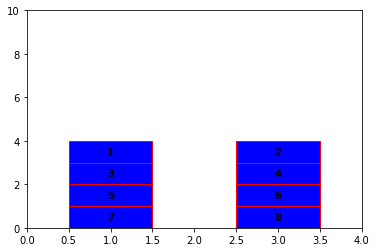

In [9]:
plot([ [7, 5, 3, 1], [8, 6, 4, 2] ])

In [10]:
SSS(*generateInputs(0), linear = True)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to klt45@cornell.edu
Optimize a model with 54 rows, 600 columns and 123 nonzeros
Model fingerprint: 0x7d115ad6
Variable types: 0 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 54 rows and 600 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, 

# Second test case

Let's verify the example from class where we get a zero objective.

$ n = 2 $ 

$ m = 4 $

$ S = \{ \{1,3\}, \{2\} \} $

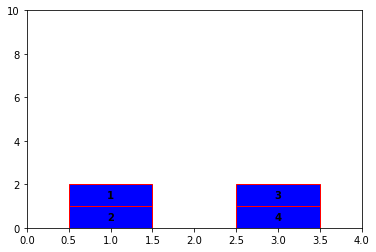

In [11]:
plot( [ [2,1] , [4,3] ] )

In [12]:
SSS(*generateInputs(1), linear = True)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to klt45@cornell.edu
Optimize a model with 17 rows, 72 columns and 35 nonzeros
Model fingerprint: 0x87dde586
Variable types: 0 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1.0000000
Presolve removed 17 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 0 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap

# Third test case

Let's verify that our calculation for the deduction $D$ is correct with one stack only. The optimal solution is slab 8 (cost of 7), slab 3 (cost of 2), slab 7 (cost of 5), slab 9 (cost of 5) for a total cost of 19.


$ n = 4 $

$ m = 9 $

$ S = \{ \{7,8\}, \{3,4\}, \{7\}, \{9\} \} $


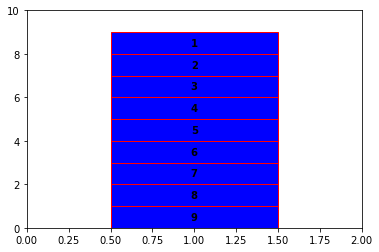

In [13]:
plot( [list(range(9, 0, -1))] )

In [14]:
SSS(*generateInputs(2), linear = True)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to klt45@cornell.edu
Optimize a model with 79 rows, 1332 columns and 186 nonzeros
Model fingerprint: 0x7dbf9915
Variable types: 0 continuous, 1332 integer (1332 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 19.0000000
Presolve removed 79 rows and 1332 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.06 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 19 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.900000000000e+01, best bound 1.900000000000

# Optimal objective: 207 (ran for 6 hours and still didn't finish)

Sadly, the **linear formulation** blows out my RAM due to the 4-D decision variable $y_{ijkl}$ , but the **quadratic formulation** obtains the same objective as Professor Frans <3 


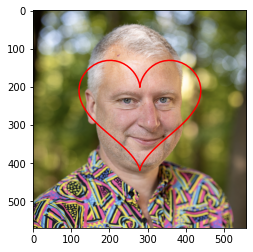

In [15]:
from PIL import Image
img = Image.open('dad.png')
fig, ax = plt.subplots()
ax.imshow(img)
t = np.linspace(0, 2*np.pi, 100)
x = -10*(16*np.sin(t)**3) + 280
y= -10*(13*np.cos(t)-5*np.cos(2*t)-2*np.cos(3*t)-np.cos(4*t)) + 250
ax.plot(x, y, color='r')
plt.show()

In [16]:
SSS(*generateInputs(3), linear = False)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license - for non-commercial use only - registered to klt45@cornell.edu
Optimize a model with 12305 rows, 12500 columns and 37005 nonzeros
Model fingerprint: 0x5bd76de1
Model has 17115 quadratic objective terms
Variable types: 0 continuous, 12500 integer (12500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  QObjective range [2e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1595.0000000
Presolve removed 12105 rows and 12005 columns
Presolve time: 0.73s
Presolved: 200 rows, 495 columns, 917 nonzeros
Presolved model has 17609 quadratic objective terms
Variable types: 0 continuous, 495 integer (495 binary)
Found heuristic solution: objective 419.00000